In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

x, y, z = np.mgrid[0:1:199j, 0:1:199j, 0:1:199j]
# Need an (N, 2) array of (x, y) pairs.
xyz = np.column_stack([x.flat, y.flat, z.flat])

mu = np.array([.5, .5, 0])

sigma = np.array([.25, .25, .15])
covariance = np.diag(sigma**2)

val = multivariate_normal.pdf(xyz, mean=mu, cov=covariance)

# Reshape back to a (30, 30) grid.
val = val.reshape(x.shape)

# Normalize max to 100 (ppmv) and transpose so orientation is correct (z up)
val = val.T*(100/val.max())

In [2]:
#plt.contourf(val[:, :, 100])
#val[:, :, 100].max()

In [3]:
new_o3_vals = np.ma.array(np.array([val]), mask=False, dtype='float32')

In [4]:
# Code via https://stackoverflow.com/questions/15141563/python-netcdf-making-a-copy-of-all-variables-and-attributes-but-one
# User Rich Signell
from netCDF4 import Dataset

toexclude = ['o3']

src = Dataset("wrfinput_d01")
dst = Dataset("wrfinput_d01_new", "w")

# copy global attributes all at once via dictionary
dst.setncatts(src.__dict__)
# copy dimensions
for name, dimension in src.dimensions.items():
    dst.createDimension(
        name, (len(dimension) if not dimension.isunlimited() else None))
# copy all file data except for the excluded
for name, variable in src.variables.items():
    if name not in toexclude:
        x = dst.createVariable(name, variable.datatype, variable.dimensions)
        dst[name][:] = src[name][:]
        # copy variable attributes all at once via dictionary
        dst[name].setncatts(src[name].__dict__)
    else:
        x = dst.createVariable(name, variable.datatype, variable.dimensions)
        dst[name][:] = new_o3_vals
        # copy variable attributes all at once via dictionary
        dst[name].setncatts(src[name].__dict__)
        
src.close()
dst.close()
    

In [5]:
origin_ncfile = Dataset("/data/keeling/a/sf20/b/WRF4_4/WRF/test/em_les/wrfinput_d01")
new_ncfile = Dataset("/data/keeling/a/sf20/b/WRF4_4/WRF/test/em_les/wrfinput_d01_new")

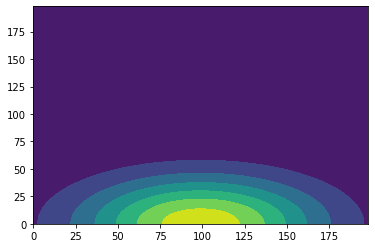

In [6]:
saved_o3_data = new_ncfile.variables['o3'][:].data[0]
plt.contourf(saved_o3_data[:, :, 100])